In [1]:
import face_recognition
import cv2
import matplotlib.pyplot as plt

In [2]:
import time
import threading
try:
    from greenlet import getcurrent as get_ident
except ImportError:
    try:
        from thread import get_ident
    except ImportError:
        from _thread import get_ident


class CameraEvent(object):
    """An Event-like class that signals all active clients when a new frame is
    available.
    """
    def __init__(self):
        self.events = {}

    def wait(self):
        """Invoked from each client's thread to wait for the next frame."""
        ident = get_ident()
        if ident not in self.events:
            # this is a new client
            # add an entry for it in the self.events dict
            # each entry has two elements, a threading.Event() and a timestamp
            self.events[ident] = [threading.Event(), time.time()]
        return self.events[ident][0].wait()

    def set(self):
        """Invoked by the camera thread when a new frame is available."""
        now = time.time()
        remove = None
        for ident, event in self.events.items():
            if not event[0].isSet():
                # if this client's event is not set, then set it
                # also update the last set timestamp to now
                event[0].set()
                event[1] = now
            else:
                # if the client's event is already set, it means the client
                # did not process a previous frame
                # if the event stays set for more than 5 seconds, then assume
                # the client is gone and remove it
                if now - event[1] > 5:
                    remove = ident
        if remove:
            del self.events[remove]

    def clear(self):
        """Invoked from each client's thread after a frame was processed."""
        self.events[get_ident()][0].clear()


class BaseCamera(object):
    thread = None  # background thread that reads frames from camera
    frame = None  # current frame is stored here by background thread
    last_access = 0  # time of last client access to the camera
    event = CameraEvent()

    def __init__(self):
        """Start the background camera thread if it isn't running yet."""
        if BaseCamera.thread is None:
            BaseCamera.last_access = time.time()

            # start background frame thread
            BaseCamera.thread = threading.Thread(target=self._thread)
            BaseCamera.thread.start()

            # wait until frames are available
            while self.get_frame() is None:
                time.sleep(0)

    def get_frame(self):
        """Return the current camera frame."""
        BaseCamera.last_access = time.time()

        # wait for a signal from the camera thread
        BaseCamera.event.wait()
        BaseCamera.event.clear()

        return BaseCamera.frame

    @staticmethod
    def frames():
        """"Generator that returns frames from the camera."""
        raise RuntimeError('Must be implemented by subclasses.')

    @classmethod
    def _thread(cls):
        """Camera background thread."""
        print('Starting camera thread.')
        frames_iterator = cls.frames()
        for frame in frames_iterator:
            BaseCamera.frame = frame
            BaseCamera.event.set()  # send signal to clients
            time.sleep(0)

            # if there hasn't been any clients asking for frames in
            # the last 10 seconds then stop the thread
            if time.time() - BaseCamera.last_access > 10:
                frames_iterator.close()
                print('Stopping camera thread due to inactivity.')
                break
        BaseCamera.thread = None

In [3]:
class Camera_compare(BaseCamera):
    video_source = 0
    last_encoding = []


    @staticmethod
    def set_video_source(source):
        Camera_compare.video_source = source

    @staticmethod
    def frames():
        camera = cv2.VideoCapture(Camera_compare.video_source)
        if not camera.isOpened():
            raise RuntimeError('Could not start camera.')


        while True:
            # read current frame
            _, frame = camera.read()

            # Convert the image from BGR color (which OpenCV uses) to RGB color (which face_recognition uses)
            rgb_frame = frame #frame[:, :, ::-1]

            # Find all the faces and face enqcodings in the frame of video
            face_locations = face_recognition.face_locations(rgb_frame)
            face_encodings = face_recognition.face_encodings(rgb_frame, face_locations)

            # Loop through each face in this frame of video
            iter = 0
            for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):
                # See if the face is a match for the known face(s)
                if len(Camera_compare.last_encoding)!=0:
                    compare_result = face_recognition.face_distance([Camera_compare.last_encoding], face_encoding)
                else:
                    compare_result = 0
                if iter == 0:
                    Camera_compare.last_encoding = face_encoding
           
                iter += 1

                #print compare faces result
                #print("Difference %s"%compare_result)
                print("Last encoding sum: %s"%(sum(Camera_compare.last_encoding)))
                
                # Draw a box around the face
                cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)

                # Draw a label with a name below the face
                cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
                #font = cv2.FONT_HERSHEY_DUPLEX
                #cv2.putText(frame, name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)

            # encode as a jpeg image and return it
            #yield cv2.imencode('.jpg', frame)[1].tobytes()
            yield frame

In [6]:
import time
for i in range(20):
    frame = Camera_compare().get_frame()
    cv2.imwrite('../data/out/%s.png'%i,frame)
    time.sleep(2)
    

Starting camera thread.
Last encoding sum: -0.30965106515213847
Last encoding sum: 0.3436380522325635
Last encoding sum: 0.20398527942597866
Last encoding sum: 0.2686667959205806
Last encoding sum: 0.46443526609800756
Last encoding sum: 0.008713653776794672
Last encoding sum: -0.13963205344043672
Last encoding sum: -0.13298673188546672
Last encoding sum: -0.12536353524774313
Last encoding sum: -0.14754992281086743
Last encoding sum: -0.018714641104452312
Last encoding sum: -0.1999360996996984
Last encoding sum: -0.15194408036768436
Last encoding sum: -0.1181768854148686
Last encoding sum: -0.04389052698388696
Last encoding sum: -0.34885753819253296
Last encoding sum: 0.033207325148396194
Last encoding sum: -0.0139775350689888
Last encoding sum: -0.49014448607340455
Last encoding sum: -0.46538395434617996
Last encoding sum: -0.5374840596923605
Last encoding sum: -0.3716076537966728
Last encoding sum: -0.20000229217112064
Last encoding sum: -0.11529122479259968
Last encoding sum: -0.2835

Stopping camera thread due to inactivity.


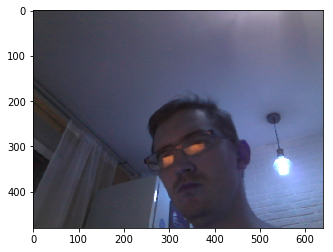

In [18]:
plt.imshow(frame)